In [3]:
from __future__ import annotations
from flamekit.io_fronts import Case, load_fronts
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

## Input Parameters

In [4]:

BASE_DIR = Path("../isocontours")
PHI = 0.40
LAT_SIZE = "200"
TIME_STEP = 230
POST = True

TARGET_VAR = "DW_FDS"
ISOLEVEL = 4.5

# -------------------------
# MISSING SETTINGS (DEFINED)
# -------------------------
CLUSTER_ON_SPATIAL = False  # if True, x,y,z can be included as clustering features

COLS_TO_EXCLUDE = {
    TARGET_VAR,
    "c_iso",
    "cluster",
    "cluster_conf",
    # exclude coordinates by default (unless CLUSTER_ON_SPATIAL=True)
    "x", "y", "z",
}

N_CLUSTERS = 8
GMM_PARAMS = dict(
    covariance_type="full",
    reg_covar=1e-6,
    max_iter=300,
    n_init=5,
    random_state=0,
)

MIN_CLUSTER_SAMPLES = 200
TEST_SIZE = 0.25
RANDOM_STATE = 0

MODEL_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

TOPN_PRINT = 12
TOPN_HEATMAP = 25


Loaded ISO 4.5: raw n=15863, after clean n=15863
GMM AIC: -4621195.00
GMM BIC: -4554857.42

Cluster summary:
 cluster    n  sd_mean   sd_std  conf_mean     x_mean     y_mean
       0 1174 0.651882 0.297815   0.996997 161.346191 113.239937
       1 5728 0.068508 0.157046   0.999451 251.887390 123.968086
       2 1807 1.241786 0.092066   0.996734 134.063446  90.307770
       3 1554 1.489773 0.117649   0.995168 152.561188 110.511284
       4 1475 0.344640 0.318769   0.997682 159.583298 111.961220
       5  969 1.339021 0.259792   0.996683 159.964981 115.112045
       6 2424 0.343560 0.290862   0.997815 171.571289 109.944809
       7  732 1.502169 2.445092   0.995911 195.953659  99.569664


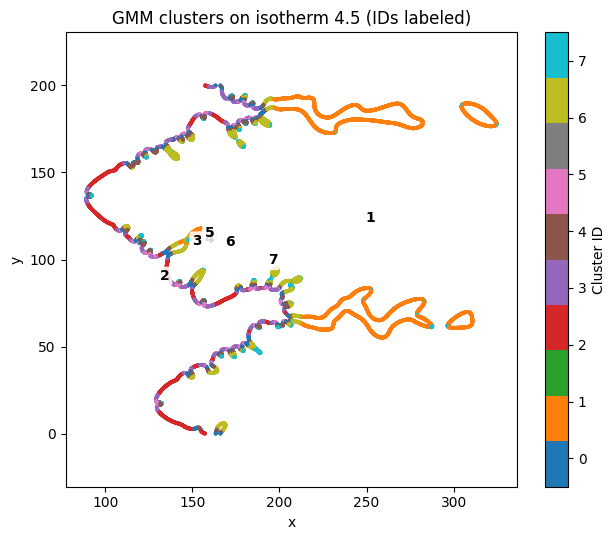


--- Cluster 0 | n=1174 ---
R^2=0.9858 | RMSE=3.598881e-02
Importance method: shap
Top features:
  01. H2O  (1.3986e-01)
  02. FDS_diff_velocity_term  (1.1065e-01)
  03. N2  (3.0441e-02)
  04. strain_rate  (1.1124e-02)
  05. FDS_src_term  (9.1838e-03)
  06. H2O2  (8.6935e-03)
  07. H_diffusion_total  (7.8960e-03)
  08. omega_H  (6.2344e-03)
  09. stretch_rate  (3.8113e-03)
  10. H2_diffusion_total  (2.9351e-03)
  11. p  (2.6723e-03)
  12. flow_velocity_normal  (1.8593e-03)


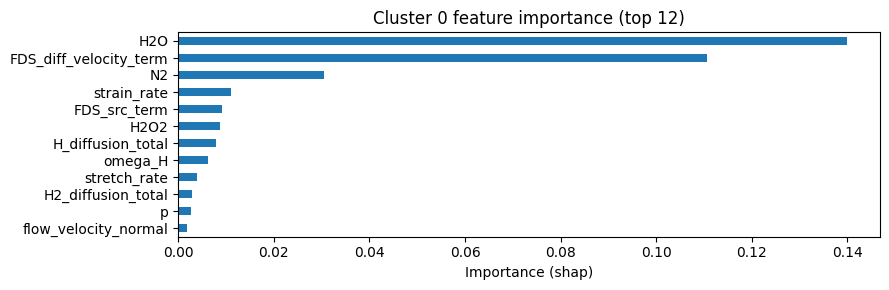


--- Cluster 1 | n=5728 ---
R^2=0.9999 | RMSE=1.742917e-03
Importance method: shap
Top features:
  01. FDS_diffusion_term  (1.2639e-01)
  02. total_heat_conduction  (5.8097e-04)
  03. FDS_src_term  (1.0162e-04)
  04. omega_H2  (3.8105e-05)
  05. O2_diffusion_total  (3.6055e-05)
  06. p  (3.5956e-05)
  07. heat_conduction_tangential  (3.5652e-05)
  08. curvature  (3.5494e-05)
  09. FDS_diff_velocity_term  (3.3580e-05)
  10. u  (3.3259e-05)
  11. heat_conduction_normal  (3.3064e-05)
  12. gradT  (2.9513e-05)


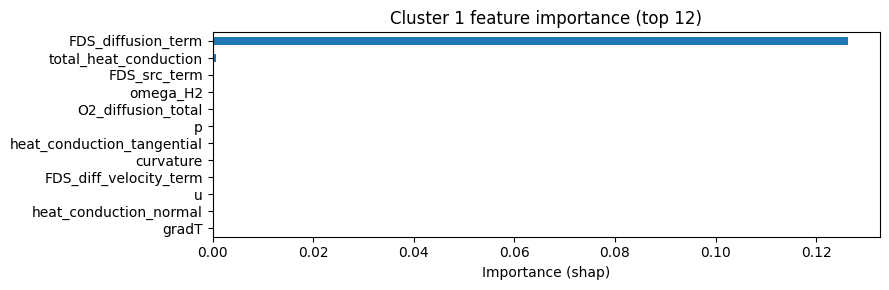


--- Cluster 2 | n=1807 ---
R^2=0.9975 | RMSE=4.643567e-03
Importance method: shap
Top features:
  01. H2O  (5.4925e-02)
  02. gradT  (1.4817e-02)
  03. omega_H2O2  (1.2749e-02)
  04. strain_rate  (7.0259e-03)
  05. OH  (3.5199e-03)
  06. omega_HO2  (1.5872e-03)
  07. tangential_strain_rate  (1.4184e-03)
  08. N2  (1.3702e-03)
  09. u  (1.3372e-03)
  10. p  (1.2136e-03)
  11. H  (1.1656e-03)
  12. O  (1.0928e-03)


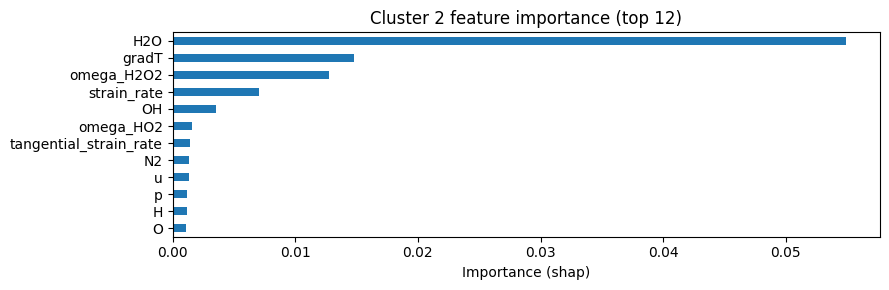


--- Cluster 3 | n=1554 ---
R^2=0.9927 | RMSE=9.873048e-03
Importance method: shap
Top features:
  01. H2O  (7.2667e-02)
  02. gradT  (2.4994e-02)
  03. strain_rate  (7.4153e-03)
  04. omega_HO2  (4.9322e-03)
  05. stretch_rate  (2.2436e-03)
  06. N2  (2.1645e-03)
  07. v  (1.5617e-03)
  08. flow_velocity_normal  (1.3775e-03)
  09. OH  (1.0117e-03)
  10. HO2  (7.4495e-04)
  11. H2O2  (6.8191e-04)
  12. FDS_src_term  (6.5707e-04)


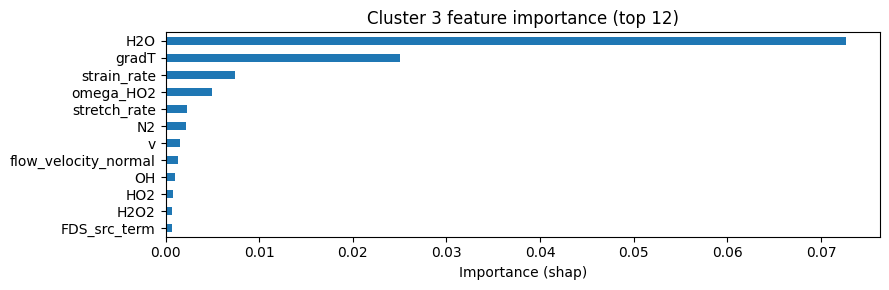


--- Cluster 4 | n=1475 ---


In [ ]:


CASE = Case(
    base_dir=BASE_DIR,
    phi=PHI,
    lat_size=LAT_SIZE,
    time_step=TIME_STEP,
    post=POST,
)

fronts = load_fronts(CASE, [ISOLEVEL])
df = fronts[ISOLEVEL].copy()
df["c_iso"] = float(ISOLEVEL)


# =========================
# Feature utilities
# =========================

def numeric_feature_list(df: pd.DataFrame, exclude: List[str]) -> List[str]:
    return [
        c for c in df.columns
        if (c not in exclude) and pd.api.types.is_numeric_dtype(df[c])
    ]


def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    plt.figure(figsize=(6.5, 5.5))
    sc = plt.scatter(
        dfc["x"], dfc["y"],
        c=dfc["cluster"],
        s=3,
        cmap="tab10",
        vmin=-0.5,
        vmax=n_clusters - 0.5,
    )
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

    cbar = plt.colorbar(sc, ticks=np.arange(n_clusters))
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])

    centroids_xy = dfc.groupby("cluster")[["x", "y"]].mean().reset_index()
    for _, row in centroids_xy.iterrows():
        cl = int(row["cluster"])
        plt.text(
            row["x"], row["y"], str(cl),
            ha="center", va="center",
            fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, ec="none"),
        )

    plt.tight_layout()
    plt.show()


# =========================
# Importance (SHAP preferred, fallback to permutation)
# =========================

def compute_importance(
        model,
        X_test: np.ndarray,
        y_test: np.ndarray,
        feature_names: List[str],
        prefer_shap: bool = True,
        random_state: int = 0,
) -> Tuple[pd.Series, str]:
    """
    Returns:
      importance: pd.Series indexed by feature_names
      method: "shap" or "permutation"
    """
    if prefer_shap:
        try:
            import shap  # type: ignore
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test)  # (n_samples, n_features)
            imp = np.mean(np.abs(shap_vals), axis=0)
            s = pd.Series(imp, index=feature_names).sort_values(ascending=False)
            return s, "shap"
        except Exception:
            pass

    pi = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1,
        scoring="r2",
    )
    s = pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False)
    return s, "permutation"


# ============================================================
# RUN (Notebook cell)
# ============================================================

if TARGET_VAR not in df.columns:
    raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found in dataframe.")

# Choose clustering features
exclude_for_cluster = list(COLS_TO_EXCLUDE)
if CLUSTER_ON_SPATIAL:
    for c in ["x", "y", "z"]:
        if c in exclude_for_cluster:
            exclude_for_cluster.remove(c)

cluster_features = numeric_feature_list(df, exclude=exclude_for_cluster)
if len(cluster_features) == 0:
    raise ValueError("No numeric clustering features left after exclusions.")

# Model features (same as clustering features by default)
model_features = cluster_features
feature_names = list(model_features)

# Clean rows (require model_features + target)
dfc = df.dropna(subset=model_features + [TARGET_VAR]).copy()
print(f"Loaded ISO {ISOLEVEL}: raw n={len(df)}, after clean n={len(dfc)}")

# Standardize for GMM
Xc = dfc[cluster_features].to_numpy()
scaler = StandardScaler()
Xc_s = scaler.fit_transform(Xc)

# Fit GMM + assign clusters
gmm = GaussianMixture(n_components=N_CLUSTERS, **GMM_PARAMS)
dfc["cluster"] = gmm.fit_predict(Xc_s)

# Optional: membership confidence (max posterior prob)
probs = gmm.predict_proba(Xc_s)
dfc["cluster_conf"] = probs.max(axis=1)

# Diagnostics: BIC/AIC
print(f"GMM AIC: {gmm.aic(Xc_s):.2f}")
print(f"GMM BIC: {gmm.bic(Xc_s):.2f}")

# Cluster summary
summary = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        conf_mean=("cluster_conf", "mean"),
    )
    .reset_index()
    .sort_values("cluster")
)

if "x" in dfc.columns and "y" in dfc.columns:
    xy = (
        dfc.groupby("cluster")[["x", "y"]]
        .mean()
        .reset_index()
        .rename(columns={"x": "x_mean", "y": "y_mean"})
    )
    summary = summary.merge(xy, on="cluster", how="left")

print("\nCluster summary:")
print(summary.to_string(index=False))

labeled_cluster_plot_xy(
    dfc, N_CLUSTERS,
    title=f"GMM clusters on isotherm {ISOLEVEL} (IDs labeled)"
)

# Train separate model per cluster and compute importance
importances: Dict[int, pd.Series] = {}
metrics: List[dict] = []
used_method: Dict[int, str] = {}

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} | n={n_cl} ---")

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    X = sub[model_features].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)

    ypred = model.predict(Xte)
    r2 = r2_score(yte, ypred)
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    print(f"R^2={r2:.4f} | RMSE={rmse:.6e}")

    imp, method = compute_importance(
        model=model,
        X_test=Xte,
        y_test=yte,
        feature_names=feature_names,
        prefer_shap=True,
        random_state=RANDOM_STATE,
    )
    used_method[cl] = method
    importances[cl] = imp

    print(f"Importance method: {method}")
    print("Top features:")
    for i, (fname, val) in enumerate(imp.head(TOPN_PRINT).items(), 1):
        print(f"  {i:02d}. {fname}  ({val:.4e})")

    metrics.append({"cluster": cl, "n": n_cl, "r2": float(r2), "rmse": rmse, "importance_method": method})

    top = imp.head(TOPN_PRINT).iloc[::-1]
    plt.figure(figsize=(9, 3))
    top.plot(kind="barh")
    plt.xlabel(f"Importance ({method})")
    plt.title(f"Cluster {cl} feature importance (top {TOPN_PRINT})")
    plt.tight_layout()
    plt.show()

# Metrics table
if metrics:
    metrics_df = pd.DataFrame(metrics).sort_values("cluster")
    print("\nPer-cluster model metrics:")
    print(metrics_df.to_string(index=False))
else:
    print("\nNo clusters satisfied MIN_CLUSTER_SAMPLES; nothing trained.")

# Compare importances across clusters (heatmap)
if importances:
    trained_clusters = sorted(importances.keys())

    # Common feature index
    common_feats = set(feature_names)
    for cl in trained_clusters:
        common_feats = common_feats.intersection(importances[cl].index.tolist())
    common_feats = list(common_feats)

    imp_mat = pd.DataFrame(index=common_feats)
    for cl in trained_clusters:
        imp_mat[f"cluster_{cl}"] = importances[cl].reindex(common_feats).fillna(0.0)

    # Normalize per cluster
    imp_norm = imp_mat.copy()
    for col in imp_norm.columns:
        s = imp_norm[col].sum()
        if s > 0:
            imp_norm[col] /= s

    imp_norm["avg"] = imp_norm.mean(axis=1)
    top_feats = imp_norm.sort_values("avg", ascending=False).head(TOPN_HEATMAP).index
    heat = imp_norm.loc[top_feats, [c for c in imp_norm.columns if c != "avg"]]

    plt.figure(figsize=(1.2 * len(trained_clusters) + 3, 0.35 * len(top_feats) + 2))
    plt.imshow(heat.to_numpy(), aspect="auto")
    plt.xticks(np.arange(len(heat.columns)), heat.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(heat.index)), heat.index)
    plt.colorbar(label="Normalized importance (per cluster)")
    plt.title(f"Feature-importance comparison across clusters (top {TOPN_HEATMAP} by avg)")
    plt.tight_layout()
    plt.show()

    print("\nTop features (normalized importance per cluster):")
    print(heat.round(4).to_string())
